---
# 0️⃣ Data Load

In [64]:
import numpy as np
import pandas as pd

from pandas.api.types import is_string_dtype, is_numeric_dtype
from moda.dataprep import raw_to_ts, ts_to_range
import lasio
import math
import joypy
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats import mode

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from dtaidistance import dtw
from dtaidistance import clustering

import time
from datetime import datetime, date, timedelta

import datetime as dt
import urllib
from urllib.error import URLError, HTTPError
import os
from dateutil import parser

import seaborn as sns
import matplotlib as mpl
import matplotlib.cbook as cbook
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

import koreanize_matplotlib
from highlight_text import fig_text, ax_text

import calmap
import calplot
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
import dataframe_image as dfi
from PIL import Image

## 경고메세지 숨기기
import warnings
warnings.filterwarnings(action='ignore')
## 숨겼던 경고메세지 다시 보이게하기
# warnings.filterwarnings(action='default')

## 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

%matplotlib inline
# pd.options.display.float_format='{:.2f}'.format

## -------------------------------------------------------------------------------- ## ->|
YJPATH = r"F:/YJ-RnDnote-WS/data/"
YJPATH3 = r'F:/YJ-format-230125/data/'
NCPATH = r"C:/app/Git-WS/2022/local-yjtest/23-YJ-RnDnote/YJH-RnDnote-WS/data/"
INDIR = r"001_pbp_raw/" 
OUTDIR = r"002_pbp_interim/"
OUTDIR3 = r'interim/'

kf = pd.read_csv('F:/YJ-RnDnote-WS/data/003_kbo_record_raw/KBO-record-c-0122.csv', encoding='utf-8')
color = pd.read_csv("F:/YJ-format-230125/data/team_colors3.csv", encoding='cp949')

raw = pd.read_csv(YJPATH + OUTDIR + r'pbp-zone-2023-02-20-2.csv', encoding='cp949', low_memory=False)
raw["game_date"] = pd.to_datetime(raw.game_date, format='%Y-%m-%d')

def two_digit(n): 
    return f"{n:02d}"
raw['bs_cnt']=raw['bs_cnt'].apply(two_digit)

def six_digit(n): 
    return f"{n:06d}"
raw['bso_rcnt']=raw['bso_rcnt'].apply(six_digit)

raw.drop_duplicates(inplace=True)
raw.shape

(1308468, 184)

---
# 1️⃣ Data get Interval

In [2]:
d = datetime.today().date()
pf = pd.read_csv(r'F:/YJ-format-230125/data/interim/pbp-zone-2023-02-21.csv', encoding="cp949", low_memory=False)

pf.drop_duplicates(inplace=True)
pf.shape # 1차 (2030182, 71)

def calculate_dt(dt):
    game_dt = datetime.strptime(dt, "%Y-%m-%d") # game_dt = datetime.strptime(dt, "%Y%m%d").date()
    return game_dt
pf["game_date"] = pf["game_date"].apply(calculate_dt)

## FA 전팀
CATCHER = ['권정웅-65412', '박세혁-62244', '안중열-64022', '박동원-79365', '허도환-77243', '양의지-76232', '유강남-61102', '이재용-67993', '주효상-66354']
TEAM = ['SS', 'DS', 'LG', 'KIA', 'HH', 'NC', 'LG', 'NC', 'WO']
for c, t in zip(CATCHER, TEAM):
    pf['p_team'] = np.where((pf['yy']==2022) & (pf['cid']=='{}'.format(c)), '{}'.format(t), pf['p_team'])
    pf['a_team'] = np.where((pf['yy']==2022) & (pf['cid']=='{}'.format(c)), '{}'.format(t), pf['a_team'])
    pf['h_team'] = np.where((pf['yy']==2022) & (pf['cid']=='{}'.format(c)), '{}'.format(t), pf['h_team'])

In [3]:
gid = pf.query("yy==2022").groupby(['cid']).agg(gid_cnt=('gid','nunique')).reset_index().sort_values('gid_cnt',ascending=False)
labels = [7, 6, 5, 4, 3, 2, 1, 0]; bins = [0, 6, 30, 50, 80, 100, 120, 140]
gid_bins = pd.cut(gid['gid_cnt'] ,bins, labels=labels[:-1])

## merge
gid['score'] = gid_bins
df22=pd.merge(pf, gid, on='cid', how='left')

score = df22.groupby(['catcher']).agg(score = ('score', 'unique')).reset_index()
score['score'] = score['score'].str[0]
score = score.sort_values('score', ascending=True)
score

,catcher,score
51,유강남,1.0
63,이지영,1.0
38,박세혁,1.0
84,최재훈,2.0
36,박동원,2.0
...,...,...
81,차일목,NaN
82,최경철,NaN
85,프레이타스,NaN
87,한준수,NaN


### 1) pitch_Array

In [4]:
d = datetime.today().date()
ydpt = pd.read_csv('F:/YJ-format-230125/data/interim/pbp-arr-first-last-2023-02-22-2.csv', encoding="cp949", low_memory=False)
ydpt.drop_duplicates(inplace=True)
ydpt.shape # 1차 (2030182, 71)

def calculate_dt(dt):
    game_dt = datetime.strptime(dt, "%Y-%m-%d") # game_dt = datetime.strptime(dt, "%Y%m%d").date()
    return game_dt
ydpt["game_date"] = ydpt["game_date"].apply(calculate_dt)

## FA 전팀
CATCHER = ['권정웅-65412', '박세혁-62244', '안중열-64022', '박동원-79365', '허도환-77243', '양의지-76232', '유강남-61102', '이재용-67993', '주효상-66354']
TEAM = ['SS', 'DS', 'LG', 'KIA', 'HH', 'NC', 'LG', 'NC', 'WO']
for c, t in zip(CATCHER, TEAM):
    ydpt['p_team'] = np.where((ydpt['yy']==2022) & (ydpt['cid']=='{}'.format(c)), '{}'.format(t), ydpt['p_team'])
    ydpt['a_team'] = np.where((ydpt['yy']==2022) & (ydpt['cid']=='{}'.format(c)), '{}'.format(t), ydpt['a_team'])
    ydpt['h_team'] = np.where((ydpt['yy']==2022) & (ydpt['cid']=='{}'.format(c)), '{}'.format(t), ydpt['h_team'])

In [5]:
## seq5
ydpt['pit_seq5'] = ydpt['pit_first1'] + "|" + ydpt['pit_last4'] + "|" + ydpt['pit_last3'] + "|" + ydpt['pit_last2'] + "|" + ydpt['pit_last1']
ydpt['pit_cls4'] = ydpt['pit_cls_first1'] + "|" + ydpt['pit_cls_last4'] + "|" + ydpt['pit_cls_last3'] + "|" + ydpt['pit_cls_last2'] + "|" + ydpt['pit_cls_last1']
ydpt['z101_seq5'] = ydpt['z101_first1'].astype(str) + "|" + ydpt['z101_last4'].astype(str) + "|" + ydpt['z101_last3'].astype(str) + "|" + ydpt['z101_last2'].astype(str) + "|" + ydpt['z101_last1'].astype(str)
ydpt['z101sh_seq5'] = ydpt['z101sh_first1'] + "|" + ydpt['z101sh_last4'] + "|" + ydpt['z101sh_last3'] + "|" + ydpt['z101sh_last2'] + "|" + ydpt['z101sh_last1']
ydpt['z101th_seq5'] = ydpt['z101th_first1'] + "|" + ydpt['z101th_last4'] + "|" + ydpt['z101th_last3'] + "|" + ydpt['z101th_last2'] + "|" + ydpt['z101th_last1']
ydpt['pit_z101th_seq5'] = ydpt['pit_z101th_first1'] + "|" + ydpt['pit_z101th_last4'] + "|" + ydpt['pit_z101th_last3'] + "|" + ydpt['pit_z101th_last2'] + "|" + ydpt['pit_z101th_last1']
ydpt['pit_z101_seq5'] = ydpt['pit_z101_first1'] + "|" + ydpt['pit_z101_last4'] + "|" + ydpt['pit_z101_last3'] + "|" + ydpt['pit_z101_last2'] + "|" + ydpt['pit_z101_last1']
ydpt['pit_z101sh_seq5'] = ydpt['pit_z101sh_first1'] + "|" + ydpt['pit_z101sh_last4'] + "|" + ydpt['pit_z101sh_last3'] + "|" + ydpt['pit_z101sh_last2'] + "|" + ydpt['pit_z101sh_last1']
## seq4
ydpt['pit_seq4'] = ydpt['pit_first1'] + "|" + ydpt['pit_last3'] + "|" + ydpt['pit_last2'] + "|" + ydpt['pit_last1']
ydpt['pit_cls4'] = ydpt['pit_cls_first1'] + "|" + ydpt['pit_cls_last3'] + "|" + ydpt['pit_cls_last2'] + "|" + ydpt['pit_cls_last1']
ydpt['z101_seq4'] = ydpt['z101_first1'].astype(str)+ "|" + ydpt['z101_last3'].astype(str) + "|" + ydpt['z101_last2'].astype(str) + "|" + ydpt['z101_last1'].astype(str)
ydpt['pit_z101_seq4'] = ydpt['pit_z101_first1'] + "|" + ydpt['pit_z101_last3'] + "|" + ydpt['pit_z101_last2'] + "|" + ydpt['pit_z101_last1']
ydpt['z101sh_seq4'] = ydpt['z101sh_first1'] + "|" + ydpt['z101sh_last3'] + "|" + ydpt['z101sh_last2'] + "|" + ydpt['z101sh_last1']
ydpt['z101th_seq4'] = ydpt['z101th_first1'] + "|" + ydpt['z101th_last3'] + "|" + ydpt['z101th_last2'] + "|" + ydpt['z101th_last1']
ydpt['pit_z101th_seq4'] = ydpt['pit_z101th_first1'] + "|" + ydpt['pit_z101th_last3'] + "|" + ydpt['pit_z101th_last2'] + "|" + ydpt['pit_z101th_last1']
ydpt['pit_z101sh_seq4'] = ydpt['pit_z101sh_first1'] + "|" + ydpt['pit_z101sh_last3'] + "|" + ydpt['pit_z101sh_last2'] + "|" + ydpt['pit_z101sh_last1']

ydpt['throws_stands'] = ydpt['throws'] +'_'+ ydpt['stands']

### 2) Grouping

In [6]:
ydpt4_cid = ydpt.query("pit_len >=3").groupby(['yy', 'ym', 'game_date', 'cid', 'throws_stands', 'pit_len', 'pit_seq4']).agg(pa=('gid-intot-panum', 'count')).reset_index().sort_values(by=['cid', 'throws_stands', 'pa'], ascending=(True, True, False))
ydpt4_cid

,yy,ym,game_date,cid,throws_stands,pit_len,pit_seq4,pa
157,2017-01-01,2017-04-01,2017-04-01,강민호-74540,우_우,4,직구|직구|직구|직구,6
35570,2018-01-01,2018-06-01,2018-06-12,강민호-74540,우_우,3,직구|X|직구|직구,6
54034,2019-01-01,2019-04-01,2019-04-19,강민호-74540,우_우,3,슬라이더|X|슬라이더|슬라이더,6
54715,2019-01-01,2019-04-01,2019-04-24,강민호-74540,우_우,4,직구|슬라이더|슬라이더|슬라이더,6
151283,2022-01-01,2022-07-01,2022-07-29,강민호-74540,우_우,3,직구|X|슬라이더|슬라이더,6
...,...,...,...,...,...,...,...,...
86743,2020-01-01,2020-07-01,2020-07-09,현원회-50840,우_좌,4,직구|직구|직구|직구,2
86744,2020-01-01,2020-07-01,2020-07-09,현원회-50840,좌_우,3,직구|X|투심|직구,2
86745,2020-01-01,2020-07-01,2020-07-09,현원회-50840,좌_우,4,직구|직구|직구|슬라이더,2
86746,2020-01-01,2020-07-01,2020-07-09,현원회-50840,좌_우,8,직구|직구|직구|투심,1


In [7]:
ydpt4_cid.describe(percentiles=(.1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99, .995, .999))

,pit_len,pa
count,161876.000000,161876.000000
mean,4.564092,1.736070
std,1.425560,0.564537
min,3.000000,1.000000
10%,3.000000,1.000000
20%,3.000000,1.000000
30%,4.000000,1.000000
40%,4.000000,2.000000
50%,4.000000,2.000000
60%,5.000000,2.000000


In [8]:
ydpt4_cid = ydpt.query("pit_len >=3").groupby(['yy', 'ym', 'game_date', 'cid', 'p_team', 'pit_len', 'pit_seq4']).agg(pa=('gid-intot-panum', 'count')).reset_index().sort_values(by=['cid', 'pa'], ascending=(True, False))

## 
gid = pf.query("yy==2022").groupby(['yy', 'cid']).agg(gid_cnt=('gid','nunique')).reset_index().sort_values('gid_cnt',ascending=False)
labels = [7, 6, 5, 4, 3, 2, 1, 0]; bins = [0, 6, 30, 50, 80, 100, 120, 140]
gid_bins = pd.cut(gid['gid_cnt'] ,bins, labels=labels[:-1])

## date convert
def calculate_dt(dt):
    game_dt = datetime.strptime(dt, "%Y-%m-%d")
    return game_dt

## merge
gid['score'] = gid_bins
gid = gid[['cid', 'score']]
ydpt4_cid2 = ydpt4_cid.query("pit_len >=4")
ydpt4_cid2 = pd.merge(ydpt4_cid2, gid, on='cid', how='left')
ydpt4_cid2

,yy,ym,game_date,cid,p_team,pit_len,pit_seq4,pa,score
0,2022-01-01,2022-04-01,2022-04-05,강민호-74540,SS,5,직구|직구|직구|직구,7,3
1,2017-01-01,2017-04-01,2017-04-01,강민호-74540,LT,4,직구|직구|직구|직구,6,3
2,2018-01-01,2018-05-01,2018-05-08,강민호-74540,SS,5,직구|직구|직구|직구,6,3
3,2019-01-01,2019-03-01,2019-03-27,강민호-74540,SS,5,직구|직구|직구|직구,6,3
4,2019-01-01,2019-04-01,2019-04-24,강민호-74540,SS,4,직구|슬라이더|슬라이더|슬라이더,6,3
...,...,...,...,...,...,...,...,...,...
114226,2020-01-01,2020-07-01,2020-07-09,현원회-50840,SSG,4,직구|직구|직구|슬라이더,2,NaN
114227,2020-01-01,2020-07-01,2020-07-09,현원회-50840,SSG,4,직구|직구|직구|직구,2,NaN
114228,2020-01-01,2020-07-01,2020-07-09,현원회-50840,SSG,5,직구|직구|투심|직구,2,NaN
114229,2020-01-01,2020-07-01,2020-07-09,현원회-50840,SSG,5,슬라이더|직구|직구|포크,1,NaN


In [9]:
ydpt4_cid2 = ydpt4_cid2.sort_values(by=["cid", 'pit_seq4', 'game_date'], ascending=(False, False, True))

## game_date
ydpt4_cid2["game_date"] = pd.to_datetime(ydpt4_cid2["game_date"], format='%Y-%m-%d')
ydpt4_cid2['game_date2'] = ydpt4_cid2.groupby('pit_seq4')['game_date'].shift()
ydpt4_cid2["game_date2"] = pd.to_datetime(ydpt4_cid2["game_date2"], format='%Y-%m-%d')

## pit_seq
ydpt4_cid2['Consec_pit_seq4'] = ydpt4_cid2["pit_seq4"] == ydpt4_cid2.shift()["pit_seq4"]
ydpt4_cid2['Consec_cid'] = ydpt4_cid2["cid"] == ydpt4_cid2.shift()["cid"]
ydpt4_cid2["diff"] = ydpt4_cid2["game_date"]-ydpt4_cid2["game_date2"]
ydpt4_cid2["diff"] = np.where(((ydpt4_cid2['Consec_pit_seq4']==True)&(ydpt4_cid2['Consec_cid']==True)), ydpt4_cid2["diff"] , pd.NaT)
ydpt4_cid2["diff"] = pd.to_timedelta(ydpt4_cid2["diff"])
ydpt4_cid2["score"] = np.where((pd.isnull(ydpt4_cid2['score'])==True), 99 , ydpt4_cid2["score"])
ydpt4_cid2["score"] = ydpt4_cid2["score"].astype(int)
ydpt4_cid2.head(5)

,yy,ym,game_date,cid,p_team,pit_len,pit_seq4,pa,score,game_date2,Consec_pit_seq4,Consec_cid,diff
114228,2020-01-01,2020-07-01,2020-07-09,현원회-50840,SSG,5,직구|직구|투심|직구,2,99,NaT,False,False,NaT
114230,2020-01-01,2020-07-01,2020-07-09,현원회-50840,SSG,8,직구|직구|직구|투심,1,99,NaT,False,True,NaT
114227,2020-01-01,2020-07-01,2020-07-09,현원회-50840,SSG,4,직구|직구|직구|직구,2,99,NaT,False,True,NaT
114226,2020-01-01,2020-07-01,2020-07-09,현원회-50840,SSG,4,직구|직구|직구|슬라이더,2,99,NaT,False,True,NaT
114229,2020-01-01,2020-07-01,2020-07-09,현원회-50840,SSG,5,슬라이더|직구|직구|포크,1,99,NaT,False,True,NaT


In [10]:
ydpt4_cid22= ydpt4_cid2[pd.isnull(ydpt4_cid2['diff'])==False]
interval = ydpt4_cid2[pd.isnull(ydpt4_cid2['diff'])==False]
interval.sort_values(by=['cid','pit_seq4','game_date',], ascending=(True, True, True,))
interval3 = interval.groupby(['cid', 'p_team', 'pit_len', 'pit_seq4', 'score']).agg(pa_sum=('pa', 'sum'),diff_avg=('diff','mean'), diff_med=('diff','median'), diff_max=('diff','max'), diff_min=('diff','min')).reset_index()
interval3.head(5)

,cid,p_team,pit_len,pit_seq4,score,pa_sum,diff_avg,diff_med,diff_max,diff_min
0,강민호-74540,LT,4,슬라이더|슬라이더|슬라이더|슬라이더,3,7,8 days 12:00:00,6 days,21 days,1 days
1,강민호-74540,LT,4,슬라이더|슬라이더|슬라이더|직구,3,3,60 days 00:00:00,60 days,81 days,39 days
2,강민호-74540,LT,4,슬라이더|슬라이더|직구|슬라이더,3,2,14 days 00:00:00,14 days,14 days,14 days
3,강민호-74540,LT,4,슬라이더|슬라이더|직구|직구,3,8,25 days 09:36:00,27 days,51 days,9 days
4,강민호-74540,LT,4,슬라이더|슬라이더|커브|직구,3,2,5 days 00:00:00,5 days,5 days,5 days


---
# 2️⃣ markovclick

<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*AonqslV9VFYOSY46Gi_vwA.jpeg" height="100px">

In [68]:
from markovclick import dummy
clickstream = dummy.gen_random_clickstream(n_of_streams=100, n_of_pages=12)

from markovclick.models import MarkovClickstream
m = MarkovClickstream(clickstream)

fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(m.prob_matrix, xticklabels=m.pages, yticklabels=m.pages,cmap="YlGnBu")

from markovclick.viz import visualise_markov_chain
graph = visualise_markov_chain(m)
graph

In [72]:
clickstream

[['P3', 'P4', 'P6', 'P9', 'P0', 'P1', 'P0', 'P1', 'P9', 'P9'],
 ['P9', 'P2', 'P2', 'P9', 'P1', 'P1', 'P10', 'P11', 'P2', 'P5', 'P2'],
 ['P11', 'P7', 'P8', 'P1', 'P5', 'P1', 'P2', 'P9'],
 ['P6', 'P11', 'P8', 'P11', 'P7', 'P5', 'P3', 'P1', 'P3'],
 ['P8', 'P8', 'P4', 'P8', 'P11', 'P11', 'P1', 'P8'],
 ['P3', 'P8', 'P1', 'P4', 'P10', 'P8', 'P9', 'P7', 'P11'],
 ['P1', 'P7', 'P8', 'P6', 'P2', 'P6', 'P11', 'P5', 'P2'],
 ['P0', 'P9', 'P10', 'P5', 'P1', 'P11', 'P0', 'P3', 'P2', 'P11'],
 ['P0', 'P10', 'P0', 'P4', 'P6', 'P4', 'P7', 'P5'],
 ['P6', 'P10', 'P9', 'P10', 'P2', 'P0', 'P10', 'P3'],
 ['P8', 'P6', 'P8', 'P1', 'P3', 'P0', 'P1', 'P0', 'P8'],
 ['P11', 'P1', 'P0', 'P0', 'P9', 'P7', 'P10', 'P0', 'P6', 'P11', 'P3'],
 ['P3', 'P8', 'P7', 'P5', 'P7', 'P11', 'P6', 'P10', 'P9'],
 ['P6', 'P7', 'P6', 'P9', 'P4', 'P10', 'P5', 'P9', 'P11'],
 ['P9', 'P10', 'P7', 'P7', 'P7', 'P5', 'P1', 'P2', 'P3'],
 ['P10', 'P7', 'P5', 'P9', 'P9', 'P4', 'P7', 'P3', 'P3', 'P5', 'P5'],
 ['P1', 'P5', 'P0', 'P3', 'P9', 'P3', 

<AxesSubplot: >

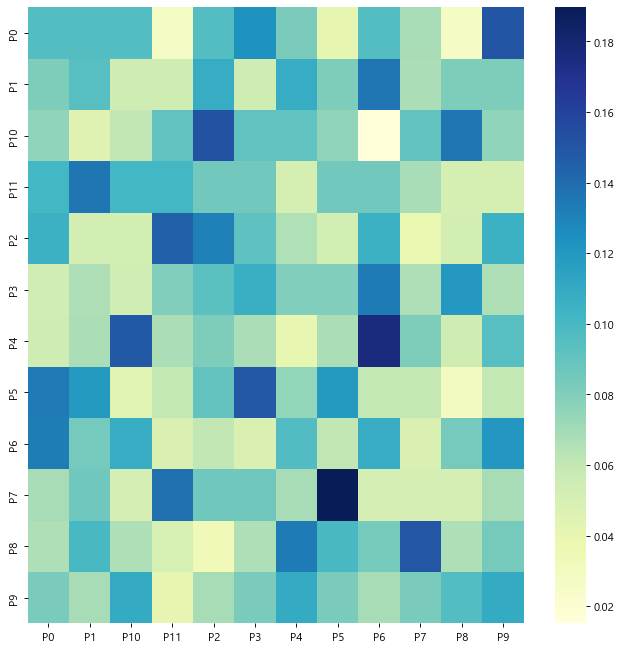

In [70]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(m.prob_matrix, xticklabels=m.pages, yticklabels=m.pages,cmap="YlGnBu")

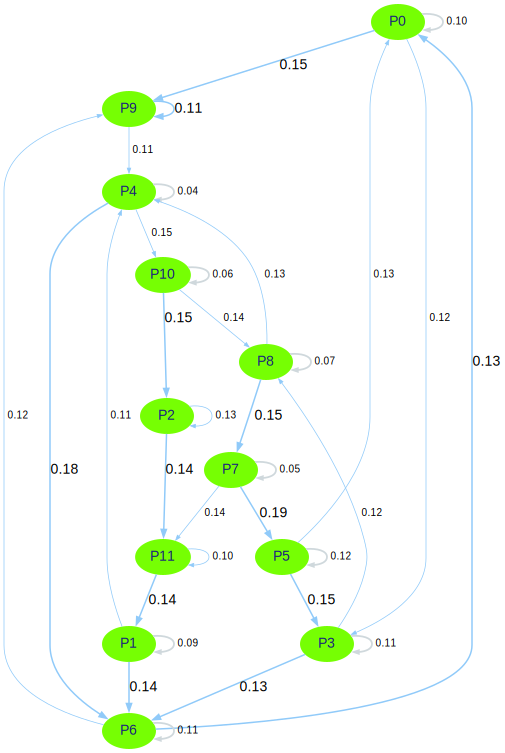

In [71]:
import os
os.environ['PATH'] += os.pathsep+'C:/Program Files/Graphviz/bin/'

from markovclick.viz import visualise_markov_chain
graph = visualise_markov_chain(m)
graph

---
---
### 1) Test

In [109]:
ydpt

,gid,game_date,cid,pid,bid,h_team,a_team,p_team,b_team,throws,...,pit_z101th_seq5,pit_z101_seq5,pit_z101sh_seq5,pit_seq4,z101_seq4,pit_z101_seq4,z101sh_seq4,z101th_seq4,pit_z101th_seq4,pit_z101sh_seq4
0,20170331-HH-DS-잠실,2017-03-31,양의지-76232,니퍼트-61240,김원석-62768,DS,HH,DS,HH,우,...,직구C|XX|XX|XX|XX,직구5|XX|XX|XX|XX,직구C|XX|XX|XX|XX,직구|X|X|X,5|X|X|X,직구5|XX|XX|XX,C|X|X|X,C|X|X|X,직구C|XX|XX|XX,직구C|XX|XX|XX
1,20170331-HH-DS-잠실,2017-03-31,양의지-76232,니퍼트-61240,김원석-62768,DS,HH,DS,HH,우,...,직구H|XX|XX|XX|XX,직구2|XX|XX|XX|XX,직구H|XX|XX|XX|XX,직구|X|X|X,2|X|X|X,직구2|XX|XX|XX,H|X|X|X,H|X|X|X,직구H|XX|XX|XX,직구H|XX|XX|XX
2,20170331-HH-DS-잠실,2017-03-31,양의지-76232,니퍼트-61240,장민석-71347,DS,HH,DS,HH,우,...,직구H|XX|XX|XX|XX,직구11|XX|XX|XX|XX,직구H|XX|XX|XX|XX,직구|X|X|X,11|X|X|X,직구11|XX|XX|XX,H|X|X|X,H|X|X|X,직구H|XX|XX|XX,직구H|XX|XX|XX
3,20170331-HH-DS-잠실,2017-03-31,조인성-98144,비야누에바-67742,박건우-79215,DS,HH,HH,DS,우,...,슬라이더I|XX|XX|XX|XX,슬라이더9|XX|XX|XX|XX,슬라이더I|XX|XX|XX|XX,슬라이더|X|X|X,9|X|X|X,슬라이더9|XX|XX|XX,I|X|X|X,I|X|X|X,슬라이더I|XX|XX|XX,슬라이더I|XX|XX|XX
4,20170331-HH-DS-잠실,2017-03-31,조인성-98144,비야누에바-67742,오재일-75334,DS,HH,HH,DS,우,...,직구O|XX|XX|XX|XX,직구1|XX|XX|XX|XX,직구O|XX|XX|XX|XX,직구|X|X|X,1|X|X|X,직구1|XX|XX|XX,O|X|X|X,O|X|X|X,직구O|XX|XX|XX,직구O|XX|XX|XX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398367,20221011-KT-LG-잠실,2022-10-11,장성우-78548,김재윤-65062,유강남-61102,LG,KT,KT,LG,우,...,슬라이더H|직구H|슬라이더I|직구O|직구H,슬라이더14|직구2|슬라이더9|직구1|직구2,슬라이더H|직구H|슬라이더I|직구O|직구H,슬라이더|슬라이더|직구|직구,14|9|1|2,슬라이더14|슬라이더9|직구1|직구2,H|I|O|H,H|I|O|H,슬라이더H|슬라이더I|직구O|직구H,슬라이더H|슬라이더I|직구O|직구H
398368,20221011-KT-LG-잠실,2022-10-11,장성우-78548,박영현-52060,김민성-77564,LG,KT,KT,LG,우,...,직구L|직구O|체인지업C|직구I|직구I,직구48|직구1|체인지업5|직구18|직구6,직구L|직구O|체인지업C|직구I|직구I,직구|체인지업|직구|직구,48|5|18|6,직구48|체인지업5|직구18|직구6,L|C|I|I,L|C|I|I,직구L|체인지업C|직구I|직구I,직구L|체인지업C|직구I|직구I
398369,20221011-KT-LG-잠실,2022-10-11,장성우-78548,박영현-52060,김민성-77564,LG,KT,KT,LG,우,...,직구L|직구O|체인지업C|직구I|직구I,직구48|직구1|체인지업5|직구18|직구6,직구L|직구O|체인지업C|직구I|직구I,직구|체인지업|직구|직구,48|5|18|6,직구48|체인지업5|직구18|직구6,L|C|I|I,L|C|I|I,직구L|체인지업C|직구I|직구I,직구L|체인지업C|직구I|직구I
398370,20221011-KT-LG-잠실,2022-10-11,장성우-78548,박영현-52060,유강남-61102,LG,KT,KT,LG,우,...,직구L|직구I|체인지업L|체인지업I|직구L,직구23|직구19|체인지업24|체인지업19|직구23,직구L|직구I|체인지업L|체인지업I|직구L,직구|체인지업|체인지업|직구,23|24|19|23,직구23|체인지업24|체인지업19|직구23,L|L|I|L,L|L|I|L,직구L|체인지업L|체인지업I|직구L,직구L|체인지업L|체인지업I|직구L


In [110]:
## seq5
ydpt['pit_seq5'] = "01-" + ydpt['pit_first1'] + "|" + "02-" + ydpt['pit_last4'] + "|" + "03-" +  ydpt['pit_last3'] + "|" + "04-" + ydpt['pit_last2'] + "|" + "05-" + ydpt['pit_last1']
ydpt['pit_cls4'] = "01-" + ydpt['pit_cls_first1'] + "|" +  "02-" +ydpt['pit_cls_last4'] + "|" +  "03-" +  ydpt['pit_cls_last3'] + "|" + "04-" + ydpt['pit_cls_last2'] + "|" +  "05-" + ydpt['pit_cls_last1']
ydpt['z101_seq5'] = "01-" + ydpt['z101_first1'].astype(str) + "|" +  "02-" +ydpt['z101_last4'].astype(str) + "|" +  "03-" +  ydpt['z101_last3'].astype(str) + "|" + "04-" + ydpt['z101_last2'].astype(str) + "|" +  "05-" + ydpt['z101_last1'].astype(str)
ydpt['z101sh_seq5'] = "01-" + ydpt['z101sh_first1'] + "|" +  "02-" +ydpt['z101sh_last4'] + "|" +  "03-" +  ydpt['z101sh_last3'] + "|" + "04-" + ydpt['z101sh_last2'] + "|" +  "05-" + ydpt['z101sh_last1']
ydpt['z101th_seq5'] = "01-" + ydpt['z101th_first1'] + "|" +  "02-" +ydpt['z101th_last4'] + "|" +  "03-" +  ydpt['z101th_last3'] + "|" + "04-" + ydpt['z101th_last2'] + "|" +  "05-" + ydpt['z101th_last1']
ydpt['pit_z101th_seq5'] = "01-" + ydpt['pit_z101th_first1'] + "|" +  "02-" +ydpt['pit_z101th_last4'] + "|" +  "03-" +  ydpt['pit_z101th_last3'] + "|" + "04-" + ydpt['pit_z101th_last2'] + "|" +  "05-" + ydpt['pit_z101th_last1']
ydpt['pit_z101_seq5'] = "01-" + ydpt['pit_z101_first1'] + "|" +  "02-" +ydpt['pit_z101_last4'] + "|" +  "03-" +  ydpt['pit_z101_last3'] + "|" + "04-" + ydpt['pit_z101_last2'] + "|" +  "05-" + ydpt['pit_z101_last1']
ydpt['pit_z101sh_seq5'] = "01-" + ydpt['pit_z101sh_first1'] + "|" +  "02-" +ydpt['pit_z101sh_last4'] + "|" +  "03-" +  ydpt['pit_z101sh_last3'] + "|" + "04-" + ydpt['pit_z101sh_last2'] + "|" +  "05-" + ydpt['pit_z101sh_last1']
## seq4
ydpt['pit_seq4'] = "01-" + ydpt['pit_first1'] + "|" +  "02-" +ydpt['pit_last3'] + "|" +  "03-" +  ydpt['pit_last2'] + "|" + "04-" + ydpt['pit_last1']
ydpt['pit_cls4'] = "01-" + ydpt['pit_cls_first1'] + "|" +  "02-" +ydpt['pit_cls_last3'] + "|" +  "03-" +  ydpt['pit_cls_last2'] + "|" + "04-" + ydpt['pit_cls_last1']
ydpt['z101_seq4'] = "01-" + ydpt['z101_first1'].astype(str)+ "|" +  "02-" +ydpt['z101_last3'].astype(str) + "|" +  "03-" +  ydpt['z101_last2'].astype(str) + "|" + "04-" + ydpt['z101_last1'].astype(str)
ydpt['pit_z101_seq4'] = "01-" + ydpt['pit_z101_first1'] + "|" +  "02-" +ydpt['pit_z101_last3'] + "|" +  "03-" +  ydpt['pit_z101_last2'] + "|" + "04-" + ydpt['pit_z101_last1']
ydpt['z101sh_seq4'] = "01-" + ydpt['z101sh_first1'] + "|" +  "02-" +ydpt['z101sh_last3'] + "|" +  "03-" +  ydpt['z101sh_last2'] + "|" + "04-" + ydpt['z101sh_last1']
ydpt['z101th_seq4'] = "01-" + ydpt['z101th_first1'] + "|" +  "02-" +ydpt['z101th_last3'] + "|" +  "03-" +  ydpt['z101th_last2'] + "|" + "04-" + ydpt['z101th_last1']
ydpt['pit_z101th_seq4'] = "01-" + ydpt['pit_z101th_first1'] + "|" +  "02-" +ydpt['pit_z101th_last3'] + "|" +  "03-" +  ydpt['pit_z101th_last2'] + "|" + "04-" + ydpt['pit_z101th_last1']
ydpt['pit_z101sh_seq4'] = "01-" + ydpt['pit_z101sh_first1'] + "|" +  "02-" +ydpt['pit_z101sh_last3'] + "|" +  "03-" +  ydpt['pit_z101sh_last2'] + "|" + "04-" + ydpt['pit_z101sh_last1']

In [119]:
ydpt4= ydpt.query("pit_len >=4")

In [121]:
seq22=ydpt4.groupby(['pit_seq4']).agg(pit=('pit_seq_str', 'count')).reset_index()

In [122]:
pit_seq_list = list(seq22['pit_seq4'].str.split('|'))

In [123]:
pit_seq_list 

[['01-너클볼', '02-너클볼', '03-너클볼', '04-너클볼'],
 ['01-너클볼', '02-너클볼', '03-너클볼', '04-직구'],
 ['01-너클볼', '02-너클볼', '03-너클볼', '04-체인지업'],
 ['01-너클볼', '02-너클볼', '03-너클볼', '04-투심'],
 ['01-너클볼', '02-너클볼', '03-슬라이더', '04-슬라이더'],
 ['01-너클볼', '02-너클볼', '03-슬라이더', '04-직구'],
 ['01-너클볼', '02-너클볼', '03-체인지업', '04-너클볼'],
 ['01-너클볼', '02-너클볼', '03-체인지업', '04-커브'],
 ['01-너클볼', '02-너클볼', '03-커브', '04-슬라이더'],
 ['01-너클볼', '02-슬라이더', '03-너클볼', '04-직구'],
 ['01-너클볼', '02-슬라이더', '03-직구', '04-체인지업'],
 ['01-너클볼', '02-직구', '03-너클볼', '04-직구'],
 ['01-너클볼', '02-직구', '03-직구', '04-슬라이더'],
 ['01-너클볼', '02-직구', '03-직구', '04-직구'],
 ['01-너클볼', '02-직구', '03-직구', '04-체인지업'],
 ['01-너클볼', '02-직구', '03-직구', '04-투심'],
 ['01-너클볼', '02-직구', '03-체인지업', '04-너클볼'],
 ['01-너클볼', '02-직구', '03-체인지업', '04-직구'],
 ['01-너클볼', '02-직구', '03-체인지업', '04-커브'],
 ['01-너클볼', '02-직구', '03-커브', '04-포크'],
 ['01-너클볼', '02-직구', '03-투심', '04-투심'],
 ['01-너클볼', '02-체인지업', '03-너클볼', '04-너클볼'],
 ['01-너클볼', '02-체인지업', '03-너클볼', '04-직구'],
 ['01-너클볼', '02-체인지업', '0

<AxesSubplot: >

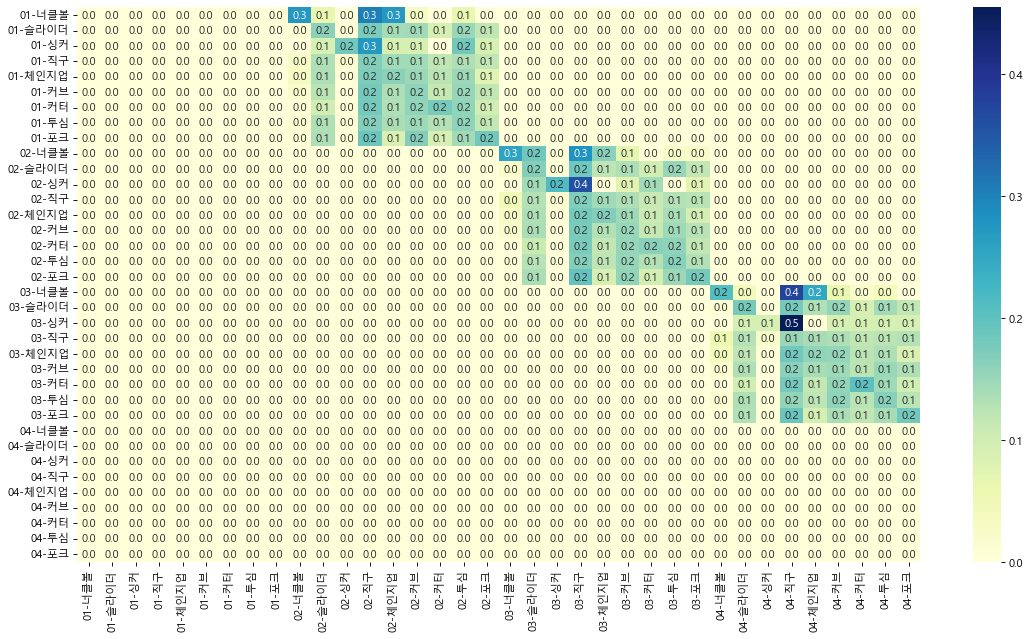

In [124]:
from markovclick.models import MarkovClickstream
m = MarkovClickstream(pit_seq_list)

fig=plt.figure(figsize=(17, 9), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(m.prob_matrix, xticklabels=m.pages, yticklabels=m.pages,cmap="YlGnBu", annot=True, fmt=".1f")

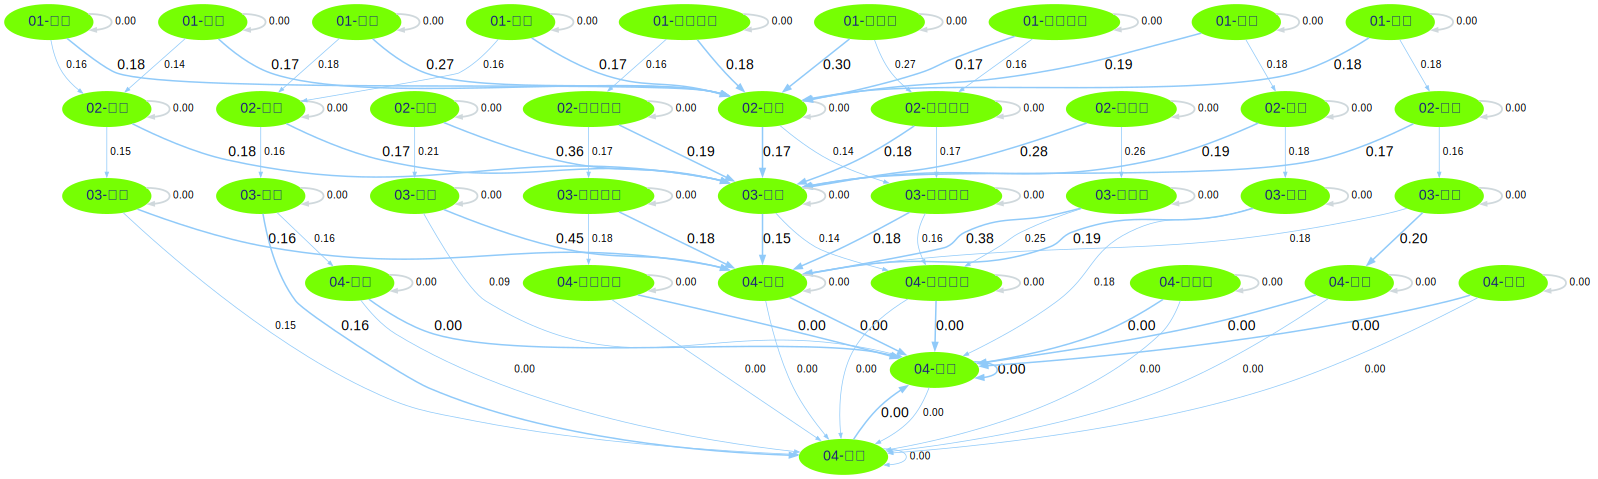

In [125]:
from markovclick.viz import visualise_markov_chain
graph = visualise_markov_chain(m)
graph

---
# REF
- https://github.com/ismailuddin/markovclick
- https://medium.com/intel-student-ambassadors/analyse-user-behaviour-optimise-the-user-workflow-using-a-machine-learning-algorithm-d538c068909c

- https://free-eunb.tistory.com/14